Notebook for preprocessing and pathways mapping.

v10 : 
- Fanny removed train_test_split to do split + cross_val in the MLP script. I leave it since I still have the non-split, "whole" dataset, but don'ignore it.
- Because of the cross_val, Fanny put the feature selection in the MLP script, so I remove it.

# Setup

## Import

In [1]:
import time
run_start = time.time()

import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

import requests
import gseapy as gp

from collections import defaultdict
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.decomposition import PCA


c:\Users\wangn\anaconda3\envs\ML_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setup

In [2]:
preprocessing_folder = Path("1_Preprocessed_gene_matrices")
pathways_folder = Path("2_Mapped_pathways_matrices")
final_folder = Path("3_Prepro_pathways_select_matrices")

for folder in [preprocessing_folder, pathways_folder, final_folder] :
    folder.mkdir(exist_ok=True)
    # exist_ok=True : if the folder already exists, don't overwrite it.

In [3]:
expression_matrix = pd.read_csv("expression_matrix.csv", index_col=0)

labels = ['cancer_label', "survival_label"]
meta_cols = ['years_to_death', 'days_to_death', 'sample_type', 'patient', 'age_at_index', 'vital_status', 'sex', 'stage', 'grade']
label_cols = meta_cols + labels
gene_cols = [col for col in expression_matrix.columns if col not in label_cols]

print(f"   - Genes : {len(gene_cols)}")
print(f"   - Samples : {expression_matrix.shape[0]}")
print(f"   - Shape : {expression_matrix.shape}")

C:\Users\wangn\AppData\Local\Temp\ipykernel_3376\339106426.py:1: DtypeWarning: Columns (60664) have mixed types. Specify dtype option on import or set low_memory=False.
  expression_matrix = pd.read_csv("expression_matrix.csv", index_col=0)


   - Genes : 60660
   - Samples : 405
   - Shape : (405, 60671)


## Matrix exploration

In [4]:
l = len(label_cols)
expression_matrix.columns[-(l+3):]

Index(['AC006486.3', 'AL391628.1', 'AP006621.6', 'sample_type', 'cancer_label',
       'patient', 'age_at_index', 'days_to_death', 'vital_status', 'sex',
       'stage', 'grade', 'years_to_death', 'survival_label'],
      dtype='object')

In [5]:
for meta in ["sample_type", "vital_status", "sex", "stage", "grade", "age_at_index"] :
    print(f"{meta} unique values : {expression_matrix[meta].nunique()}")
    print(f"{meta} unique values : {expression_matrix[meta].unique()} \n")

sample_type unique values : 3
sample_type unique values : ['Primary Tumor' 'Solid Tissue Normal' 'Recurrent Tumor'] 

vital_status unique values : 2
vital_status unique values : ['Alive' 'Dead'] 

sex unique values : 2
sex unique values : ['male' 'female'] 

stage unique values : 9
stage unique values : ['Stage II' 'Stage I' "'--" 'Stage IIIA' 'Stage IIIC' 'Stage III'
 'Stage IIIB' 'Stage IV' 'Stage 0'] 

grade unique values : 5
grade unique values : ['G3' 'G2' "'--" 'G1' 'G4'] 

age_at_index unique values : 73
age_at_index unique values : [73 63 58 68 55 66 24 71 59 50 38 62 56 42 70 44 76 46 52 69 75 20 37 18
 74 51 48 65 45 60 67 80 72 36 78 16 43 77 57 47 53 29 64 49 26 54 81 61
 35 85 23 40 31 83 39 79 '70' '80' '72' "'--" '53' '40' '23' '64' '75'
 '66' '45' '61' 17 82 84 32 33] 



In [6]:
# Filter out patients without survival_label
alive_matrix = expression_matrix[expression_matrix["vital_status"] == "Alive"]
dead_matrix = expression_matrix[expression_matrix["survival_label"].notna()]

# Check that only dead patients are in the filtered expression_matrix
print("===== Only keeping dead patients (with survival data) in expression_matrix =====")
print("Check that only dead patients are kept :", dead_matrix["vital_status"].unique(), "   (only 'Dead' should be there)")
print("Filtered_out alive samples :", len(alive_matrix))
print("Kept dead samples :", len(dead_matrix))


===== Only keeping dead patients (with survival data) in expression_matrix =====
Check that only dead patients are kept : ['Dead']    (only 'Dead' should be there)
Filtered_out alive samples : 245
Kept dead samples : 160


In [7]:
print("\nLabels distribution :")
print(expression_matrix["survival_label"].value_counts())
print(f"   - Ratio 1/0 : {expression_matrix['survival_label'].sum() / (len(expression_matrix) - expression_matrix['survival_label'].sum()):.2f}")

print("\nPatient distribution :")
print(f"   - Unique patients : {expression_matrix['patient'].nunique()}")
patient_counts = expression_matrix.groupby("patient").size()
duplicates = patient_counts[patient_counts > 1]
print(f"   - Patients with several samples : {len(duplicates)}")
print(f"   - Alive patients, filtered-out : {len(alive_matrix)}")


Labels distribution :
survival_label
0.0    107
1.0     53
Name: count, dtype: int64
   - Ratio 1/0 : 0.15

Patient distribution :
   - Unique patients : 353
   - Patients with several samples : 51
   - Alive patients, filtered-out : 245


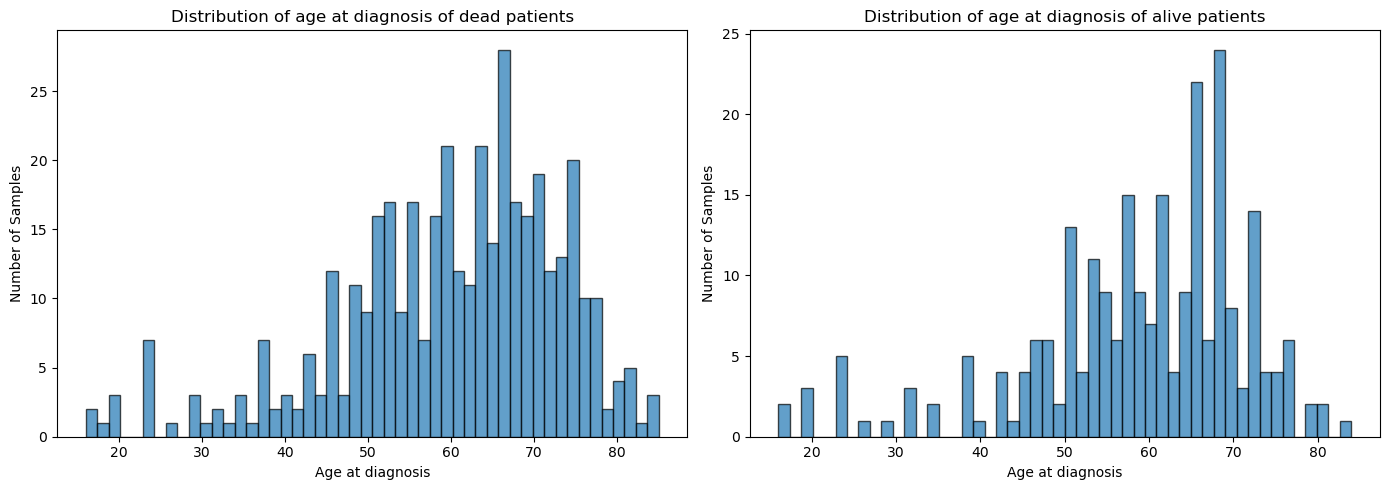

In [8]:
# Distrib age
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Age of dead patients
age_data_dead = pd.to_numeric(expression_matrix["age_at_index"], errors='coerce')
axes[0].hist(age_data_dead.dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel("Age at diagnosis")
axes[0].set_ylabel("Number of Samples")
axes[0].set_title("Distribution of age at diagnosis of dead patients")

# Age of alive patients
age_data_alive = pd.to_numeric(alive_matrix["age_at_index"], errors='coerce')
axes[1].hist(age_data_alive.dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel("Age at diagnosis")
axes[1].set_ylabel("Number of Samples")
axes[1].set_title("Distribution of age at diagnosis of alive patients")

plt.tight_layout()
plt.show()

# Quality control

## Missing values

In [9]:
# I'm too lazy to change every expression_matrix to dead_matrix, so :
expression_matrix = dead_matrix

In [10]:
# ===== Genes with missing values ===== 

missing_genes = expression_matrix[gene_cols].isna().sum()
genes_with_missing = (missing_genes > 0).sum()

print(f"\nGenes with missing values : {genes_with_missing}")


Genes with missing values : 0


In [11]:
# ===== Samples with missing values ===== 

missing_samples = expression_matrix[gene_cols].isna().sum(axis=1).sum()
samples_with_missing = (missing_samples > 0).sum()

print(f"Samples with missing values : {samples_with_missing}")

Samples with missing values : 0


## Mitonchondrial genes percentage

In [12]:
# ===== Mitochondrial genes percentage per sample ===== 

# Identify mito genes
mito_genes = [gene for gene in gene_cols if gene.startswith("^MT-")]
print(f"Mitochondrial genes found : {len(mito_genes)}")


Mitochondrial genes found : 0


## Total count/expression in samples (sequencing depth) and genes count

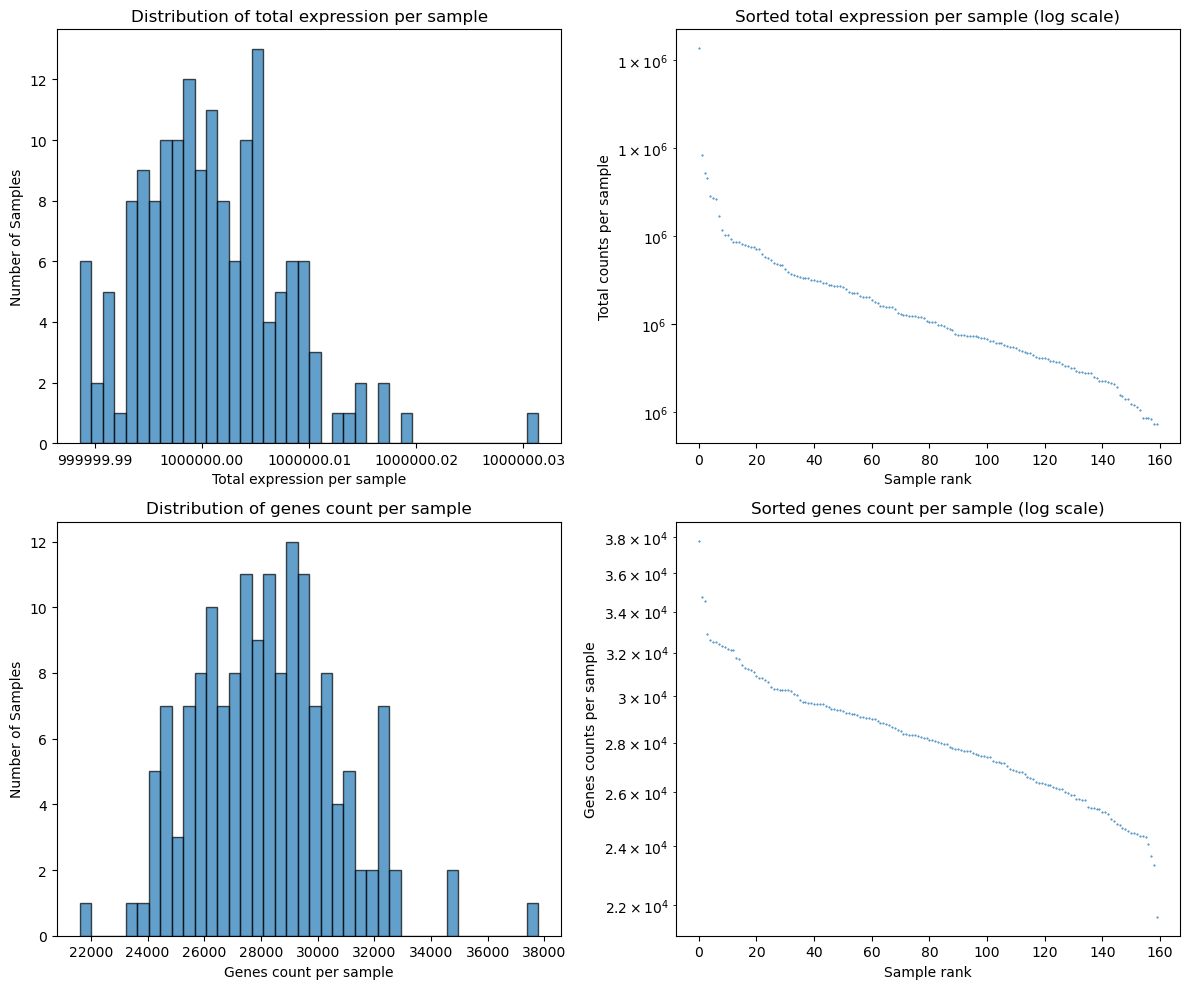

In [13]:
# ===== Total counts per sample ===== 
total_counts = expression_matrix[gene_cols].sum(axis=1)

# ===== Number of genes expressed in samples =====
genes_count = (expression_matrix[gene_cols] > 0).sum(axis=1)

# ===== Plot =====
plt.figure(figsize=(12, 10))

# Histogram of total counts
plt.subplot(2, 2, 1)
plt.hist(total_counts, bins=40, edgecolor='black', alpha=0.7)
plt.xlabel("Total expression per sample")
plt.ylabel("Number of Samples")
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.ticklabel_format(style='plain', axis='x')
plt.title("Distribution of total expression per sample")

# Knee plot of total counts
plt.subplot(2, 2, 2)
x = range(len(total_counts))
y = sorted(total_counts, reverse=True)
plt.scatter(x, y, s=0.2)
plt.xlabel("Sample rank")
plt.ylabel("Total counts per sample")
plt.title("Sorted total expression per sample (log scale)")
plt.yscale("log")

# Histogram of genes count
plt.subplot(2, 2, 3)
plt.hist(genes_count, bins=40, edgecolor='black', alpha=0.7)
plt.xlabel("Genes count per sample")
plt.ylabel("Number of Samples")
plt.title("Distribution of genes count per sample")

# Knee plot of genes count
plt.subplot(2, 2, 4)
x = range(len(genes_count))
y = sorted(genes_count, reverse=True)
plt.scatter(x, y, s=0.2)
plt.xlabel("Sample rank")
plt.ylabel("Genes counts per sample")
plt.title("Sorted genes count per sample (log scale)")
plt.yscale("log")

plt.tight_layout()
plt.show()

No visible low-sequencing samples or outliers.

# Preprocessing + split

## Removal of non expressed and lowly expressed genes

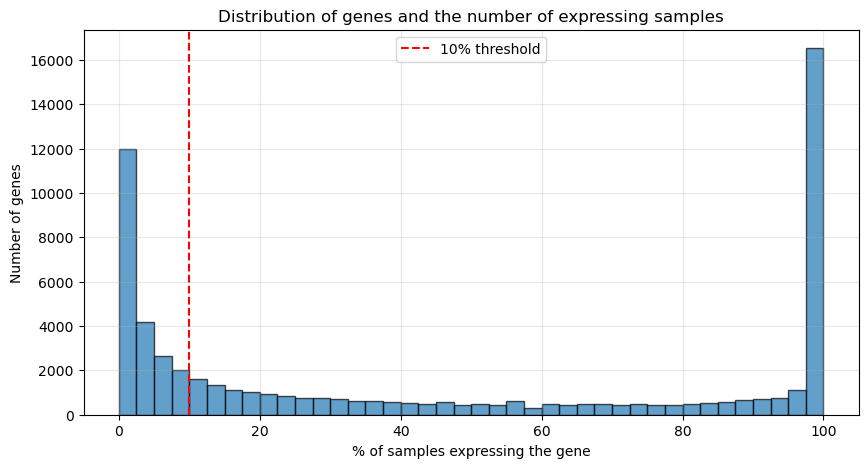

In [14]:
# ===== Non expressed and lowly expressed genes ===== 

# For each gene, count how many samples express it (expression > 0)
samples_expressing_genes = (expression_matrix[gene_cols] > 0).sum(axis=0)

# Calculate for each gene, in how many samples it's expressed, in %
total_samples = len(expression_matrix)
percent_expressing = (samples_expressing_genes / total_samples) * 100

plt.figure(figsize=(10, 5))
plt.hist(percent_expressing, bins=40, edgecolor='black', alpha=0.7)
plt.xlabel('% of samples expressing the gene')
plt.ylabel('Number of genes')
plt.title('Distribution of genes and the number of expressing samples')
plt.axvline(10, color='red', linestyle='--', label='10% threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [15]:
# Only keep genes expressed in more than 10% of samples

# Series of genes expressed in more than 10% of samples
genes_high = percent_expressing[percent_expressing > 10].index.tolist()     # New genes list

print("===== Filtering : removal of lowly expressed genes =====")
print(f"Before : {len(gene_cols)} genes")

expression_matrix_filt = expression_matrix[genes_high + label_cols]     # New filtered matrix
genes_out = len(gene_cols) - len(genes_high)
genes_out_pc = genes_out / len(gene_cols) *100

print(f"After : {len(genes_high)} gènes")
print(f"Filtered out : {genes_out} genes   = {genes_out_pc:.2f} %")


===== Filtering : removal of lowly expressed genes =====
Before : 60660 genes
After : 39336 gènes
Filtered out : 21324 genes   = 35.15 %


## Train-Test Split

Split dataset into training and testing datasets, with a matrix containing features and metavariables (X), and the label column apart (y).

In [16]:
# ===== Train-Test Split =====
split_genes_dt = {}     # dict to store split matrices

meta_cols = [col for col in label_cols if col not in ['survival_label']]
X = expression_matrix_filt[genes_high + meta_cols]
y = expression_matrix_filt['survival_label']

X_train_genes_filt, X_test_genes_filt, y_train_genes_filt, y_test_genes_filt = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42,
    stratify=y
)

# Get indices for reference
train_indices = X_train_genes_filt.index
test_indices = X_test_genes_filt.index

# Store split matrices
split_genes_dt["whole"] = X, y
split_genes_dt["training"] = X_train_genes_filt, y_train_genes_filt
split_genes_dt["testing"] = X_test_genes_filt, y_test_genes_filt

print("===== Train-Test Split =====")
print(f"Training set: {X_train_genes_filt.shape[0]} samples")
print(f"Test set:     {X_test_genes_filt.shape[0]} samples")
print(f"\nClass distribution in training set:")
print(y_train_genes_filt.value_counts())
print(f"\nClass distribution in test set:")
print(y_test_genes_filt.value_counts())

===== Train-Test Split =====
Training set: 112 samples
Test set:     48 samples

Class distribution in training set:
survival_label
0.0    75
1.0    37
Name: count, dtype: int64

Class distribution in test set:
survival_label
0.0    32
1.0    16
Name: count, dtype: int64


## Log transformation

In [17]:
trans_genes_dt = {}     # dict to store transformed matrices

for name, (genes_matrix_filt, labels) in split_genes_dt.items() :
    print(f"===== {name} dataset log transformation =====")
    print(f"\nBefore transformation :")
    print(f"   - Min : {genes_matrix_filt[genes_high].min().min():.2f}")
    print(f"   - Max : {genes_matrix_filt[genes_high].max().max():.2f}")
    print(f"   - Median : {genes_matrix_filt[genes_high].median().median():.2f}")

    genes_matrix_trans = genes_matrix_filt.copy()
    genes_matrix_trans[genes_high] = np.log2(genes_matrix_filt[genes_high] + 1)

    # Store in dict
    trans_genes_dt[name] = genes_matrix_trans, labels
    
    print(f"\nAfter log2(x+1) :")
    print(f"   - Min : {genes_matrix_trans[genes_high].min().min():.2f}")
    print(f"   - Max : {genes_matrix_trans[genes_high].max().max():.2f}")
    print(f"   - Median : {genes_matrix_trans[genes_high].median().median():.2f}")
    print("\n")

===== whole dataset log transformation =====

Before transformation :
   - Min : 0.00
   - Max : 158390.28
   - Median : 0.15

After log2(x+1) :
   - Min : 0.00
   - Max : 17.27
   - Median : 0.20


===== training dataset log transformation =====

Before transformation :
   - Min : 0.00
   - Max : 158390.28
   - Median : 0.15

After log2(x+1) :
   - Min : 0.00
   - Max : 17.27
   - Median : 0.20


===== testing dataset log transformation =====

Before transformation :
   - Min : 0.00
   - Max : 126032.83
   - Median : 0.15

After log2(x+1) :
   - Min : 0.00
   - Max : 16.94
   - Median : 0.21




In [18]:
# Save matrices
final_genes_dt = trans_genes_dt.copy()

for name, (genes_matrix_final, labels) in final_genes_dt.items() :
    genes_matrix_final.to_csv(preprocessing_folder / f"{name}_genes_matrix_preprocessed_surv.csv")

# Pathways mapping

## Mapping of genes to pathways

3 matrices : with full library pathways, with pathways selected with cancer keywords, with randomly selected pathways.

In [19]:
# Download MSigDB pathways (Hallmark = 50 well-defined pathways)
gene_sets = gp.get_library_name()  # Look at available collections
print("Available selected_selected_selected_selected_selected_msigdb Collections :", gene_sets[:10])

Available selected_selected_selected_selected_selected_msigdb Collections : ['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021']


In [20]:
# TODO: try GO instead of MSigDB.
# Use Hallmark (H) or Canonical Pathways (C2)
msigdb_full = gp.parser.download_library('GO_Biological_Process_2023', 'Human')     # dict
# Or for more pathways : 'c2.cp.v2023.1.Hs.symbols'
#msigdb = gp.parser.download_library('MSigDB_Hallmark_2020', 'Human')
#msigdb = gp.parser.download_library('MSigDB_Hallmark_2020', 'Human')
#msigdb = gp.parser.download_library('Oncogenic_Signature_2', 'Human')

# ===== Filter pathways relevant to cancer =====

cancer_keywords = [
    # General cancer terms
    'cancer', 'tumor', 'tumour', 'neoplasm', 'carcinoma', 'oncogen', 'malignant', 'sarcoma', 'lymphoma',
    
    # Key cellular processes
    'apoptosis', 'proliferation', 'cell cycle', 'cell division', 'cell growth', 'senescence',
    
    # Metastasis and invasion
    'metastasis', 'invasion', 'migration', 'adhesion', 'emt', 'epithelial mesenchymal transition', #  'extravasation',
    
    # DNA damage and repair
    'dna damage', 'dna repair', 'mutation', 'telomere',
    
    # Cellular stress
    'stress response', 'oxidative stress', 'hypoxia', 
    
    # Cancer metabolism
    'glycolysis', 'glucose', 'warburg effect', 'lactate', 'metabolism', 
    
    # Immune and microenvironment
    'immune escape', 'checkpoint', 'tumor microenvironment', 'tme',
    
    # Angiogenesis and vasculature
    'angiogenesis', 'endothelial', 'neovascularization',
    
    # Stemness and differentiation
    'stem cell', 'cancer stem', #'pluripotent', 'differentiation', 
    
    # Inflammation
    'inflammation', 'inflammatory', 'tnf', 'nf-kappa', 'cytokine', 'chemokine', 'il-6',
]

msigdb_selected = {}
for pathway_name, genes in msigdb_full.items():
    pathway_lower = pathway_name.lower()
    if any(keyword in pathway_lower for keyword in cancer_keywords):
        msigdb_selected[pathway_name] = genes
        # In msigdb dicts, a pathway key has gene values

print(f"\n{len(msigdb_selected)} filtered cancer-related pathways (out of {len(msigdb_full)} total)")
print(f"Example: {list(msigdb_selected.keys())[:3]}")


# ===== Map selected genes to pathways =====

# Make lists of genes, for the full library and for selected cancer keywords 
msigdb_full_genes = []
for genes in msigdb_full.values() :
    for g in genes :
        msigdb_full_genes.append(g)

select_msigdb_genes = []
for genes in msigdb_selected.values() :
    for g in genes :
        select_msigdb_genes.append(g)

# Make lists of genes in common between the dataset and the library
full_mapped_genes = [g for g in genes_high if g in msigdb_full_genes]
select_mapped_genes = [g for g in genes_high if g in select_msigdb_genes]
print(f"\nMapped genes in full library : {len(full_mapped_genes)}/{len(genes_high)}")
print(f"Mapped genes in selected pathways : {len(select_mapped_genes)}/{len(genes_high)}")


350 filtered cancer-related pathways (out of 3636 total)
Example: ['B Cell Proliferation (GO:0042100)', 'DNA Damage Checkpoint Signaling (GO:0000077)', 'DNA Damage Response (GO:0006974)']

Mapped genes in full library : 12935/39336
Mapped genes in selected pathways : 3972/39336


In [21]:
# Make dataframes with the genes in common between the dataset and the library
split_pathways_dt = {}

# ===== SELECT RANDOM PATHWAYS ONCE (outside loop) =====
# Set seed for reproducibility
np.random.seed(42)
random_pathway_names = np.random.choice(list(msigdb_full.keys()), size=len(msigdb_selected), replace=False)
msigdb_random = {pathway: msigdb_full[pathway] for pathway in random_pathway_names}
print(f"\n  Random pathways selected: {len(msigdb_random)}")
print(f"   Examples: {list(random_pathway_names[:3])}\n")

for dataset_name, (final_genes_matrix, labels) in final_genes_dt.items() :
    print(f"\n===== {dataset_name} dataset =====")
    
    full_pathways_matrix = pd.DataFrame(0, 
                                index=final_genes_matrix.index, 
                                columns=list(msigdb_full.keys()))
    
    select_pathways_matrix = pd.DataFrame(0, 
                                index=final_genes_matrix.index, 
                                columns=list(msigdb_selected.keys()))

    # Aggregate expression by pathway (mean)
    # Matrix with all pathways
    for pathway, genes in msigdb_full.items():
        genes_in_data = [g for g in genes if g in full_mapped_genes]
        if genes_in_data:
            full_pathways_matrix[pathway] = final_genes_matrix[genes_in_data].mean(axis=1)
    # Matrix with cancer keyword pathways
    for pathway, genes in msigdb_selected.items():
        genes_in_data = [g for g in genes if g in select_mapped_genes]
        if genes_in_data:
            select_pathways_matrix[pathway] = final_genes_matrix[genes_in_data].mean(axis=1)
    
    # Matrix with random pathways (using same random selection for all datasets)
    random_pathways_matrix = full_pathways_matrix[random_pathway_names]

    print(f"Final full matrix:     {full_pathways_matrix.shape[0]} samples × {full_pathways_matrix.shape[1]} pathways")
    print(f"Final selected matrix: {select_pathways_matrix.shape[0]} samples × {select_pathways_matrix.shape[1]} pathways")
    print(f"Final random matrix:   {random_pathways_matrix.shape[0]} samples × {random_pathways_matrix.shape[1]} pathways")

    # ----- Save pathway matrices, in a dict and in csv -----
    
    # Get features, meta_cols and labels in the matrix before saving
    full_pathways_matrix = pd.concat([full_pathways_matrix, final_genes_matrix[meta_cols], labels], axis=1)
    select_pathways_matrix = pd.concat([select_pathways_matrix, final_genes_matrix[meta_cols], labels], axis=1)
    random_pathways_matrix = pd.concat([random_pathways_matrix, final_genes_matrix[meta_cols], labels], axis=1)

    # Save in dict
    split_pathways_dt[dataset_name] = {}
    split_pathways_dt[dataset_name]["full"] = full_pathways_matrix
    split_pathways_dt[dataset_name]["selected"] = select_pathways_matrix
    split_pathways_dt[dataset_name]["random"] = random_pathways_matrix
        # NOTE: Since metadata and labels are already in final_genes_dt, I don't duplicate them.
        # Metadata are the meta_cols in X, and labels are "label" in y.

    # Save in csv
    full_pathways_matrix.to_csv(pathways_folder / f'{dataset_name}_full_pathways_matrix_surv.csv')
    with open(pathways_folder / f'{dataset_name}_full_pathway_to_genes_surv.pkl', 'wb') as f:
        pickle.dump(msigdb_full, f)

    select_pathways_matrix.to_csv(pathways_folder / f'{dataset_name}_selected_pathways_matrix_surv.csv')
    with open(pathways_folder / f'{dataset_name}_selected_pathway_to_genes_surv.pkl', 'wb') as f:
        pickle.dump(msigdb_selected, f)

    random_pathways_matrix.to_csv(pathways_folder / f'{dataset_name}_random_pathways_matrix_surv.csv')
    with open(pathways_folder / f'{dataset_name}_random_pathway_to_genes_surv.pkl', 'wb') as f:
        pickle.dump(msigdb_random, f)

# NOTE :
# Matrices now contain feature, meta_cols and labels


  Random pathways selected: 350
   Examples: [np.str_('Hexose Metabolic Process (GO:0019318)'), np.str_('Golgi Ribbon Formation (GO:0090161)'), np.str_('Cotranslational Protein Targeting To Membrane (GO:0006613)')]


===== whole dataset =====
Final full matrix:     160 samples × 3636 pathways
Final selected matrix: 160 samples × 350 pathways
Final random matrix:   160 samples × 350 pathways

===== training dataset =====
Final full matrix:     112 samples × 3636 pathways
Final selected matrix: 112 samples × 350 pathways
Final random matrix:   112 samples × 350 pathways

===== testing dataset =====
Final full matrix:     48 samples × 3636 pathways
Final selected matrix: 48 samples × 350 pathways
Final random matrix:   48 samples × 350 pathways


In [22]:
# Check matrices

for dataset_name in split_pathways_dt.keys() :
    print(f"\n========== {dataset_name} dataset ==========")

    for type_name, pathways_matrix in split_pathways_dt[dataset_name].items() :
        print(f"\n----- {type_name} pathways -----")
        print("\nFirst columns :\n")   # Should be pathways
        print(pathways_matrix.columns[:5])
        print("\nLast columns :\n")     # Last ones should be metadata and survival_label
        print(pathways_matrix.columns[-5:])
        print("\n")

# NOTE :
# split_pathways_dt[dataset_name] keys : whole, training, testing
# split_pathways_dt[dataset_name][type_name] : full, selected, random


========== whole dataset ==========

----- full pathways -----

First columns :

Index([''De Novo' AMP Biosynthetic Process (GO:0044208)',
       ''De Novo' Post-Translational Protein Folding (GO:0051084)',
       '2-Oxoglutarate Metabolic Process (GO:0006103)',
       '3'-UTR-mediated mRNA Destabilization (GO:0061158)',
       '3'-UTR-mediated mRNA Stabilization (GO:0070935)'],
      dtype='object')

Last columns :

Index(['sex', 'stage', 'grade', 'cancer_label', 'survival_label'], dtype='object')



----- selected pathways -----

First columns :

Index(['B Cell Proliferation (GO:0042100)',
       'DNA Damage Checkpoint Signaling (GO:0000077)',
       'DNA Damage Response (GO:0006974)',
       'DNA Damage Response, Signal Transduction By P53 Class Mediator (GO:0030330)',
       'DNA Damage Response, Signal Transduction By P53 Class Mediator Resulting In Cell Cycle Arrest (GO:0006977)'],
      dtype='object')

Last columns :

Index(['sex', 'stage', 'grade', 'cancer_label', 'survival_l

## Quality control

On non split data, so that we can control the entirety

### Missing values

In [23]:
# ===== Pathways with missing values ===== 

full_pathways_matrix = split_pathways_dt["whole"]["full"]
pathway_cols = [col for col in full_pathways_matrix.columns if col not in label_cols]

missing_pathways = full_pathways_matrix[pathway_cols].isna().sum()
pathways_with_missing = (missing_pathways > 0).sum()
print(f"Pathways with missing values : {pathways_with_missing}")

Pathways with missing values : 0


In [24]:
# ===== Samples with missing values ===== 

missing_samples = full_pathways_matrix[pathway_cols].isna().sum(axis=1).sum()
samples_with_missing = (missing_samples > 0).sum()

print(f"Samples with missing values : {samples_with_missing}")

Samples with missing values : 0


### Pathway expression visualizations

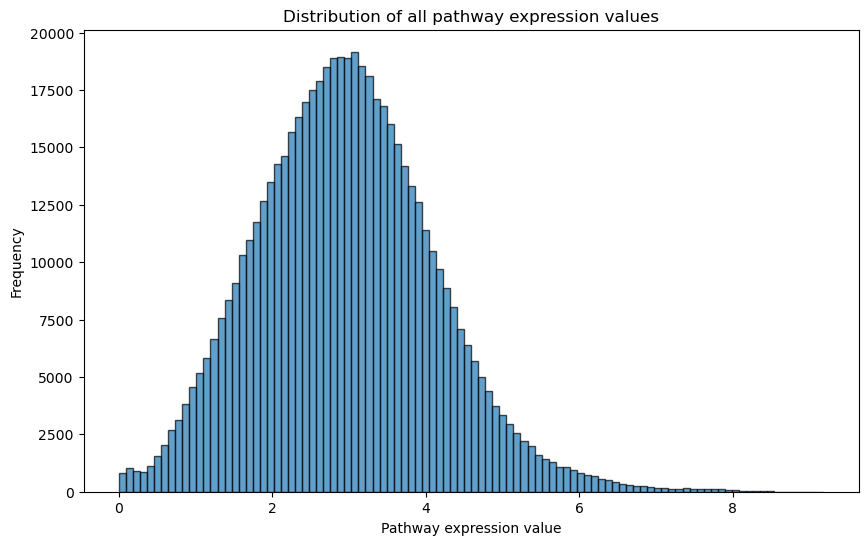

In [25]:
# Distribution of pathway expression
plt.figure(figsize=(10, 6))
plt.hist(full_pathways_matrix[pathway_cols].values.flatten(), bins=100, edgecolor='black', alpha=0.7)
plt.xlabel('Pathway expression value')
plt.ylabel('Frequency')
plt.title('Distribution of all pathway expression values')
plt.show()



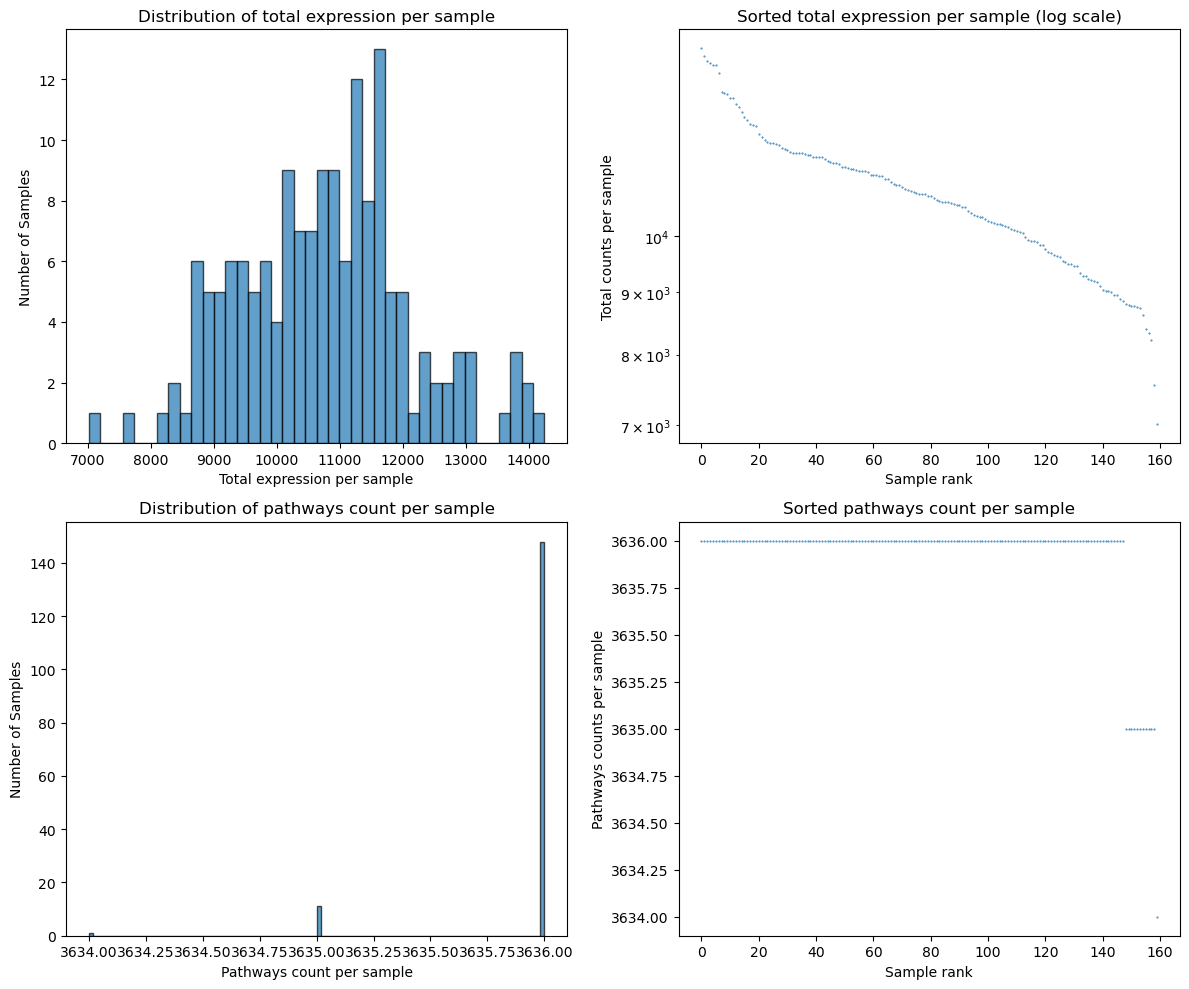

In [26]:
# ===== Total counts per sample ===== 
total_counts = full_pathways_matrix[pathway_cols].sum(axis=1)

# ===== Number of genes expressed in samples =====
pathways_count = (full_pathways_matrix[pathway_cols] > 0).sum(axis=1)

# ===== Plot =====
plt.figure(figsize=(12, 10))

# Histogram of total counts
plt.subplot(2, 2, 1)
plt.hist(total_counts, bins=40, edgecolor='black', alpha=0.7)
plt.xlabel("Total expression per sample")
plt.ylabel("Number of Samples")
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.ticklabel_format(style='plain', axis='x')
plt.title("Distribution of total expression per sample")

# Knee plot of total counts
plt.subplot(2, 2, 2)
x = range(len(total_counts))
y = sorted(total_counts, reverse=True)
plt.scatter(x, y, s=0.2)
plt.xlabel("Sample rank")
plt.ylabel("Total counts per sample")
plt.title("Sorted total expression per sample (log scale)")
plt.yscale("log")

# Histogram of pathways count
plt.subplot(2, 2, 3)
plt.hist(pathways_count, bins=100, edgecolor='black', alpha=0.7)
plt.xlabel("Pathways count per sample")
plt.ylabel("Number of Samples")
plt.title("Distribution of pathways count per sample")

# Knee plot of pathways count
plt.subplot(2, 2, 4)
x = range(len(pathways_count))
y = sorted(pathways_count, reverse=True)
plt.scatter(x, y, s=0.2)
plt.xlabel("Sample rank")
plt.ylabel("Pathways counts per sample")
plt.title("Sorted pathways count per sample")
# plt.yscale("log") 

plt.tight_layout()
plt.show()

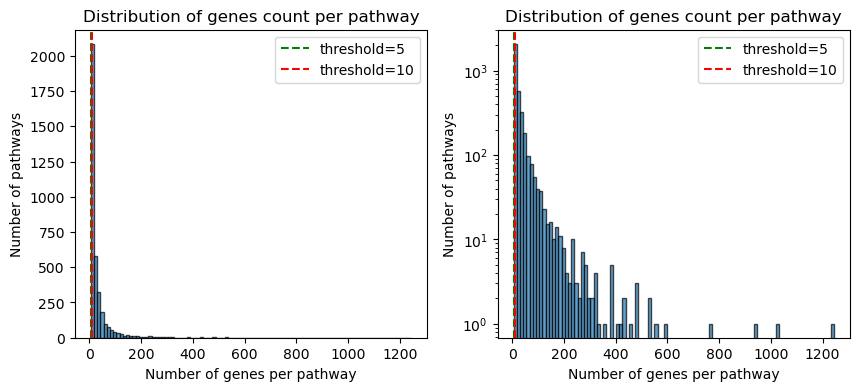

Mean genes per pathway: 31.7
Median genes per pathway: 15.0 

Pathways with < 5 genes: 0 (0.00%)
Pathways with < 10 genes: 1193 (32.81%)
Pathways with < 20 genes: 2233 (61.41%)


In [27]:
# ===== Filter pathways with a low gene count  =====

genes_per_pathway = {pathway: len(genes) for pathway, genes in msigdb_full.items()}
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(list(genes_per_pathway.values()), bins=100, edgecolor='black', alpha=0.7)
plt.xlabel('Number of genes per pathway')
plt.ylabel('Number of pathways')
plt.title('Distribution of genes count per pathway')
plt.axvline(5, label="threshold=5", color="green", linestyle="--")
plt.axvline(10, label="threshold=10", color="red", linestyle="--")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(list(genes_per_pathway.values()), bins=100, edgecolor='black', alpha=0.7)
plt.xlabel('Number of genes per pathway')
plt.ylabel('Number of pathways')
plt.title('Distribution of genes count per pathway')
plt.axvline(5, label="threshold=5", color="green", linestyle="--")
plt.axvline(10, label="threshold=10", color="red", linestyle="--")
plt.yscale("log")
plt.legend()
plt.show()

print(f"Mean genes per pathway: {np.mean(list(genes_per_pathway.values())):.1f}")
print(f"Median genes per pathway: {np.median(list(genes_per_pathway.values())):.1f} \n")

# Print statistics for pathways under different thresholds
for n in [5, 10, 20] :
    pathways_under_threshold = sum(1 for count in genes_per_pathway.values() if count < n)
    percentage = (pathways_under_threshold / len(genes_per_pathway)) * 100
    print(f"Pathways with < {n} genes: {pathways_under_threshold} ({percentage:.2f}%)")



### Filtering : pathways with few genes

In [28]:
# TODO: Add a visualization before and after filtering?

# Choose threshold and filter pathways
threshold = 10
print(f"\n===== Filtering pathways with < {threshold} genes =====")

# Filter msigdb_full
msigdb_full_filtered = {pathway: genes for pathway, genes in msigdb_full.items() 
                        if len(genes) >= threshold}


print(f"Before filtering: {len(msigdb_full)} pathways")
print(f"After filtering: {len(msigdb_full_filtered)} pathways")
print(f"Removed: {len(msigdb_full) - len(msigdb_full_filtered)}   = {((len(msigdb_full) - len(msigdb_full_filtered)) / len(msigdb_full) * 100):.2f}% pathways")

# Filter pathway_cols to match msigdb_full_filtered
pathway_cols_filtered = [col for col in pathway_cols if col in msigdb_full_filtered.keys()]

print(f"\nPathway columns before filtering: {len(pathway_cols)}")
print(f"Pathway columns after filtering: {len(pathway_cols_filtered)}")
print(f"Removed columns: {len(pathway_cols) - len(pathway_cols_filtered)}")



===== Filtering pathways with < 10 genes =====
Before filtering: 3636 pathways
After filtering: 2443 pathways
Removed: 1193   = 32.81% pathways

Pathway columns before filtering: 3636
Pathway columns after filtering: 2443
Removed columns: 1193


## Pathways scaling

In [29]:
scal_pathways_dt = {}   # dict to store scaled matrices

for dataset_name in split_pathways_dt.keys() :
    scal_pathways_dt[dataset_name] = {}     

    for type_name, matrix in split_pathways_dt[dataset_name].items() :
        pathw_cols = [col for col in matrix.columns if col not in label_cols]
        
        # ===== Standard Normalization (z-score normalization) =====
        pathw_matrix_scaled = matrix.copy()

        scaler = StandardScaler()
        pathw_matrix_scaled[pathw_cols] = scaler.fit_transform(matrix[pathw_cols])
        
        # Save in dict
        scal_pathways_dt[dataset_name][type_name] = pathw_matrix_scaled[pathw_cols + label_cols]

        # Check cols
        print(pathw_matrix_scaled.columns[-(len(label_cols)+1):])

Index(['Protein Geranylgeranylation (GO:0018344)', 'years_to_death',
       'days_to_death', 'sample_type', 'patient', 'age_at_index',
       'vital_status', 'sex', 'stage', 'grade', 'cancer_label',
       'survival_label'],
      dtype='object')
Index(['Positive Regulation Of Vascular Endothelial Growth Factor Signaling Pathway (GO:1900748)',
       'years_to_death', 'days_to_death', 'sample_type', 'patient',
       'age_at_index', 'vital_status', 'sex', 'stage', 'grade', 'cancer_label',
       'survival_label'],
      dtype='object')
Index(['Double-Strand Break Repair Via Break-Induced Replication (GO:0000727)',
       'years_to_death', 'days_to_death', 'sample_type', 'patient',
       'age_at_index', 'vital_status', 'sex', 'stage', 'grade', 'cancer_label',
       'survival_label'],
      dtype='object')
Index(['Protein Geranylgeranylation (GO:0018344)', 'years_to_death',
       'days_to_death', 'sample_type', 'patient', 'age_at_index',
       'vital_status', 'sex', 'stage', 'grade',

# Include metadata variables in the training matrix

In [30]:
print("Last dict, var_pathways_dt keys :")
for key1 in scal_pathways_dt.keys() :
    print(key1)
    for key2 in scal_pathways_dt[key1].keys() :
        print("   ", key2)

Last dict, var_pathways_dt keys :
whole
    full
    selected
    random
training
    full
    selected
    random
testing
    full
    selected
    random


## Numerical variable : age (age_at_index)

In [31]:
age_pathways_dt = {}   # dict to store matrices with scaled age as feature

for dataset_name in scal_pathways_dt.keys() :
    age_pathways_dt[dataset_name] = {}

    for type_name, matrix in scal_pathways_dt[dataset_name].items() :

        labels = ['cancer_label', "survival_label"]
        meta_cols = ['years_to_death', 'days_to_death', 'sample_type', 'patient', 'age_at_index', 'vital_status', 'sex', 'stage', 'grade']
        label_cols = meta_cols + labels
        pathw_cols = [col for col in matrix.columns if col not in label_cols]

        # ===== Standard Normalization (z-score normalization) for age only =====
        age_mtx_scaled = matrix.copy()

        scaler = StandardScaler()
        age_mtx_scaled["age_at_index"] = scaler.fit_transform(matrix[["age_at_index"]])
        
        # Save in dict
        age_pathways_dt[dataset_name][type_name] = age_mtx_scaled[pathw_cols + meta_cols + labels]

        # Check cols
        print(age_mtx_scaled.columns[-(len(label_cols)+1):])

Index(['Protein Geranylgeranylation (GO:0018344)', 'years_to_death',
       'days_to_death', 'sample_type', 'patient', 'age_at_index',
       'vital_status', 'sex', 'stage', 'grade', 'cancer_label',
       'survival_label'],
      dtype='object')
Index(['Positive Regulation Of Vascular Endothelial Growth Factor Signaling Pathway (GO:1900748)',
       'years_to_death', 'days_to_death', 'sample_type', 'patient',
       'age_at_index', 'vital_status', 'sex', 'stage', 'grade', 'cancer_label',
       'survival_label'],
      dtype='object')
Index(['Double-Strand Break Repair Via Break-Induced Replication (GO:0000727)',
       'years_to_death', 'days_to_death', 'sample_type', 'patient',
       'age_at_index', 'vital_status', 'sex', 'stage', 'grade', 'cancer_label',
       'survival_label'],
      dtype='object')
Index(['Protein Geranylgeranylation (GO:0018344)', 'years_to_death',
       'days_to_death', 'sample_type', 'patient', 'age_at_index',
       'vital_status', 'sex', 'stage', 'grade',

## Categorical : sex, cancer stage, cancer grade

One-hot encoding

In [32]:
meta_to_include = ["sex", "stage", "grade"]

for meta in meta_to_include :
    print(f"{meta} unique values : {expression_matrix[meta].nunique()}")
    print(f"{meta} unique values : {expression_matrix[meta].unique()} \n")

sex unique values : 2
sex unique values : ['female' 'male'] 

stage unique values : 9
stage unique values : ['Stage IIIA' 'Stage IIIC' 'Stage II' "'--" 'Stage I' 'Stage III'
 'Stage IV' 'Stage IIIB' 'Stage 0'] 

grade unique values : 5
grade unique values : ['G3' 'G2' "'--" 'G1' 'G4'] 



In [33]:
meta_pathways_dt = {}   # dict to store matrices with scaled age as feature
meta_to_include = ["sex", "stage", "grade"]

for dataset_name in age_pathways_dt.keys() :
    print(f"========== {dataset_name} ==========")
    meta_pathways_dt[dataset_name] = {}

    for type_name, matrix in age_pathways_dt[dataset_name].items() :
        print(f"----- {type_name} -----")

        labels = ['cancer_label', "survival_label"]
        meta_cols = ['years_to_death', 'days_to_death', 'sample_type', 'patient', 'age_at_index', 'vital_status', 'sex', 'stage', 'grade']
        label_cols = meta_cols + labels
        pathw_cols = [col for col in matrix.columns if col not in label_cols]
        
        # One-hot encoding for categorical columns
        matrix_encoded = matrix.copy()
        matrix_encoded = pd.get_dummies(matrix_encoded, columns=meta_to_include, drop_first=False, dtype=int)
            # drop_first=False keeps all categories (useful for interpretation)
            # dtype=int ensures the output is integers
        
        # Update meta_cols to include encoded categorical columns and remove original ones
        encoded_meta_cols = [col for col in matrix_encoded.columns if any(cat in col for cat in meta_to_include) and "rograde" not in col]
        meta_cols_updated = [col for col in meta_cols if col not in meta_to_include] + encoded_meta_cols
        print(f"encoded_meta_cols : {encoded_meta_cols}")
        print(f"meta_cols_updated : {meta_cols_updated} \n\n")

        # Save in dict
        meta_pathways_dt[dataset_name][type_name] = matrix_encoded[pathw_cols + meta_cols_updated + labels]

========== whole ==========
----- full -----
encoded_meta_cols : ['sex_female', 'sex_male', "stage_'--", 'stage_Stage 0', 'stage_Stage I', 'stage_Stage II', 'stage_Stage III', 'stage_Stage IIIA', 'stage_Stage IIIB', 'stage_Stage IIIC', 'stage_Stage IV', "grade_'--", 'grade_G1', 'grade_G2', 'grade_G3', 'grade_G4']
meta_cols_updated : ['years_to_death', 'days_to_death', 'sample_type', 'patient', 'age_at_index', 'vital_status', 'sex_female', 'sex_male', "stage_'--", 'stage_Stage 0', 'stage_Stage I', 'stage_Stage II', 'stage_Stage III', 'stage_Stage IIIA', 'stage_Stage IIIB', 'stage_Stage IIIC', 'stage_Stage IV', "grade_'--", 'grade_G1', 'grade_G2', 'grade_G3', 'grade_G4'] 


----- selected -----
encoded_meta_cols : ['sex_female', 'sex_male', "stage_'--", 'stage_Stage 0', 'stage_Stage I', 'stage_Stage II', 'stage_Stage III', 'stage_Stage IIIA', 'stage_Stage IIIB', 'stage_Stage IIIC', 'stage_Stage IV', "grade_'--", 'grade_G1', 'grade_G2', 'grade_G3', 'grade_G4']
meta_cols_updated : ['years_

In [34]:
# Check one-hot encoding : columns and values
meta_pathways_dt["whole"]["full"].iloc[:5, -30:]

,Protein Desumoylation (GO:0016926),Protein Deubiquitination (GO:0016579),Protein Deubiquitination Involved In Ubiquitin-Dependent Protein Catabolic Process (GO:0071947),Protein Exit From Endoplasmic Reticulum (GO:0032527),Protein Export From Nucleus (GO:0006611),Protein Geranylgeranylation (GO:0018344),years_to_death,days_to_death,sample_type,patient,...,stage_Stage IIIB,stage_Stage IIIC,stage_Stage IV,grade_'--,grade_G1,grade_G2,grade_G3,grade_G4,cancer_label,survival_label
TCGA-ED-A8O6-01A,0.295224,0.439279,0.191180,0.282240,0.566184,0.657475,0.153425,56.0,Primary Tumor,12,...,0,0,0,0,0,0,1,0,1,0.0
TCGA-DD-A1EJ-11A,-0.544084,-0.709330,0.185409,-0.806222,-0.700463,-0.784202,2.753425,1005.0,Solid Tissue Normal,14,...,0,1,0,0,0,1,0,0,0,1.0
TCGA-DD-A114-11A,-0.341901,-0.225965,0.273715,-0.415323,-0.217420,-0.878520,3.147945,1149.0,Solid Tissue Normal,17,...,0,0,0,0,0,0,1,0,0,1.0
TCGA-CC-5261-01A,2.041105,1.989357,1.984404,1.835594,1.994868,2.079400,0.265753,97.0,Primary Tumor,19,...,0,0,0,0,0,1,0,0,1,0.0
TCGA-BC-A10T-11A,-1.208192,-1.562555,-1.143698,-2.077821,-1.645746,-1.648995,2.293151,837.0,Solid Tissue Normal,20,...,0,0,0,1,0,0,0,0,0,1.0


## Projections after metadata inclusion

c:\Users\wangn\anaconda3\envs\ML_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


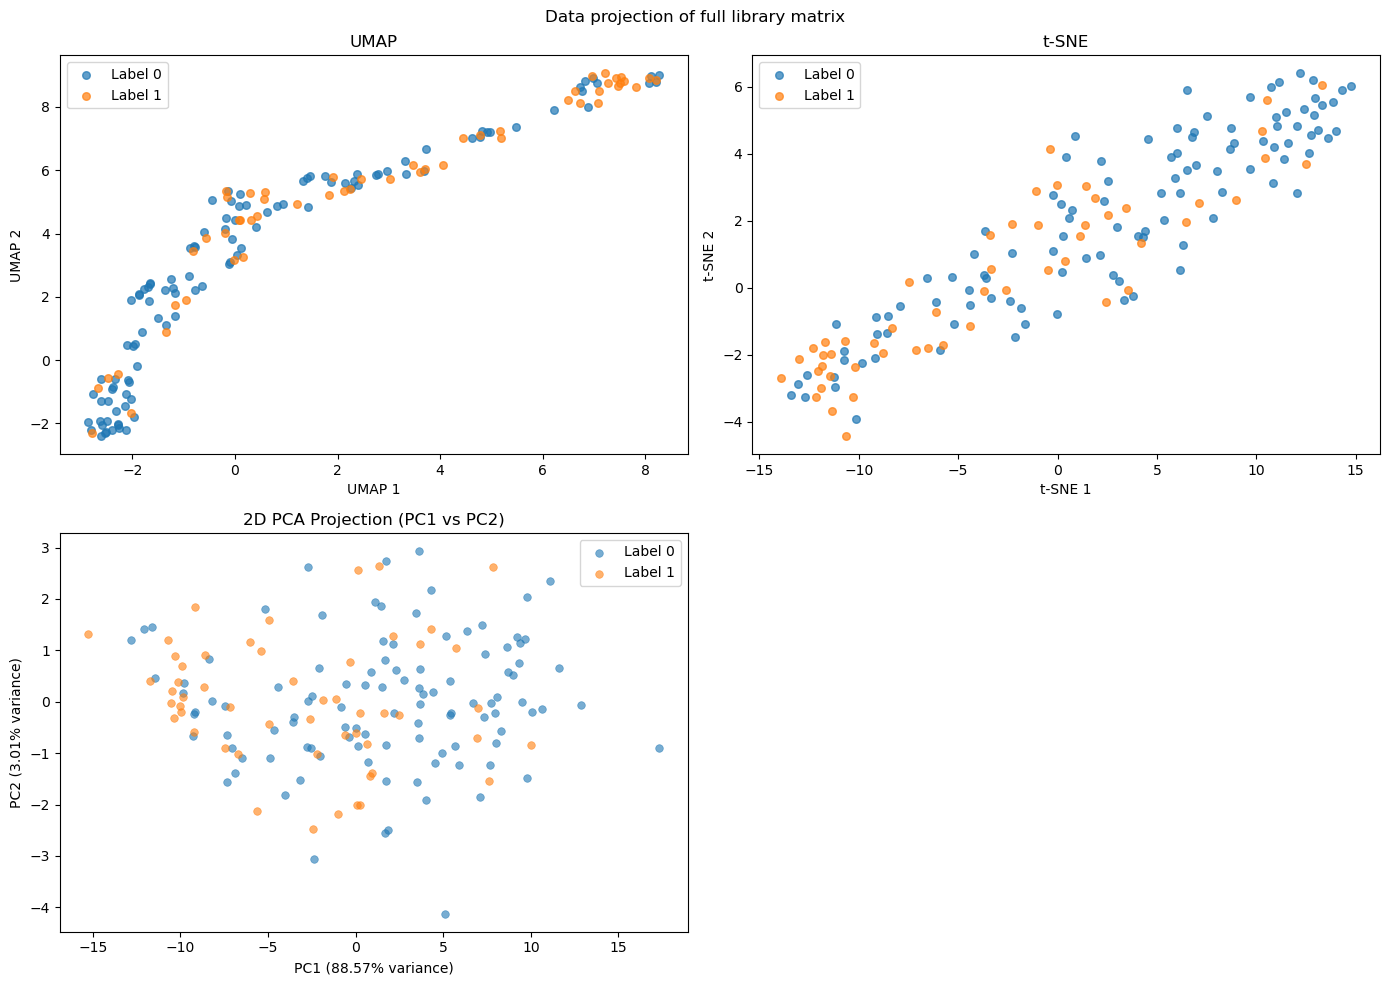

c:\Users\wangn\anaconda3\envs\ML_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


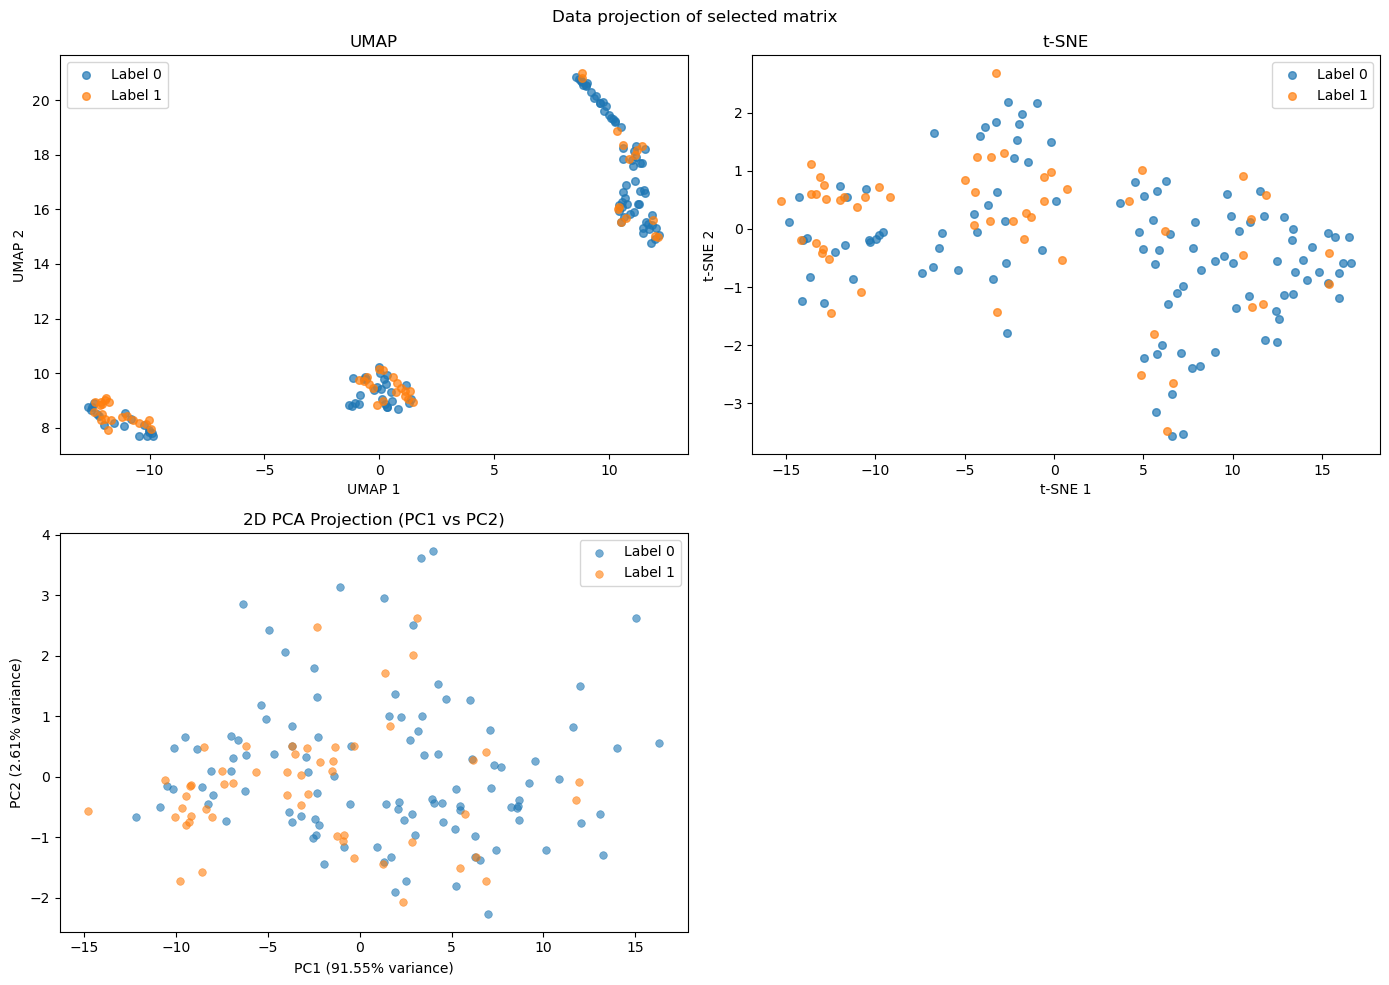

c:\Users\wangn\anaconda3\envs\ML_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


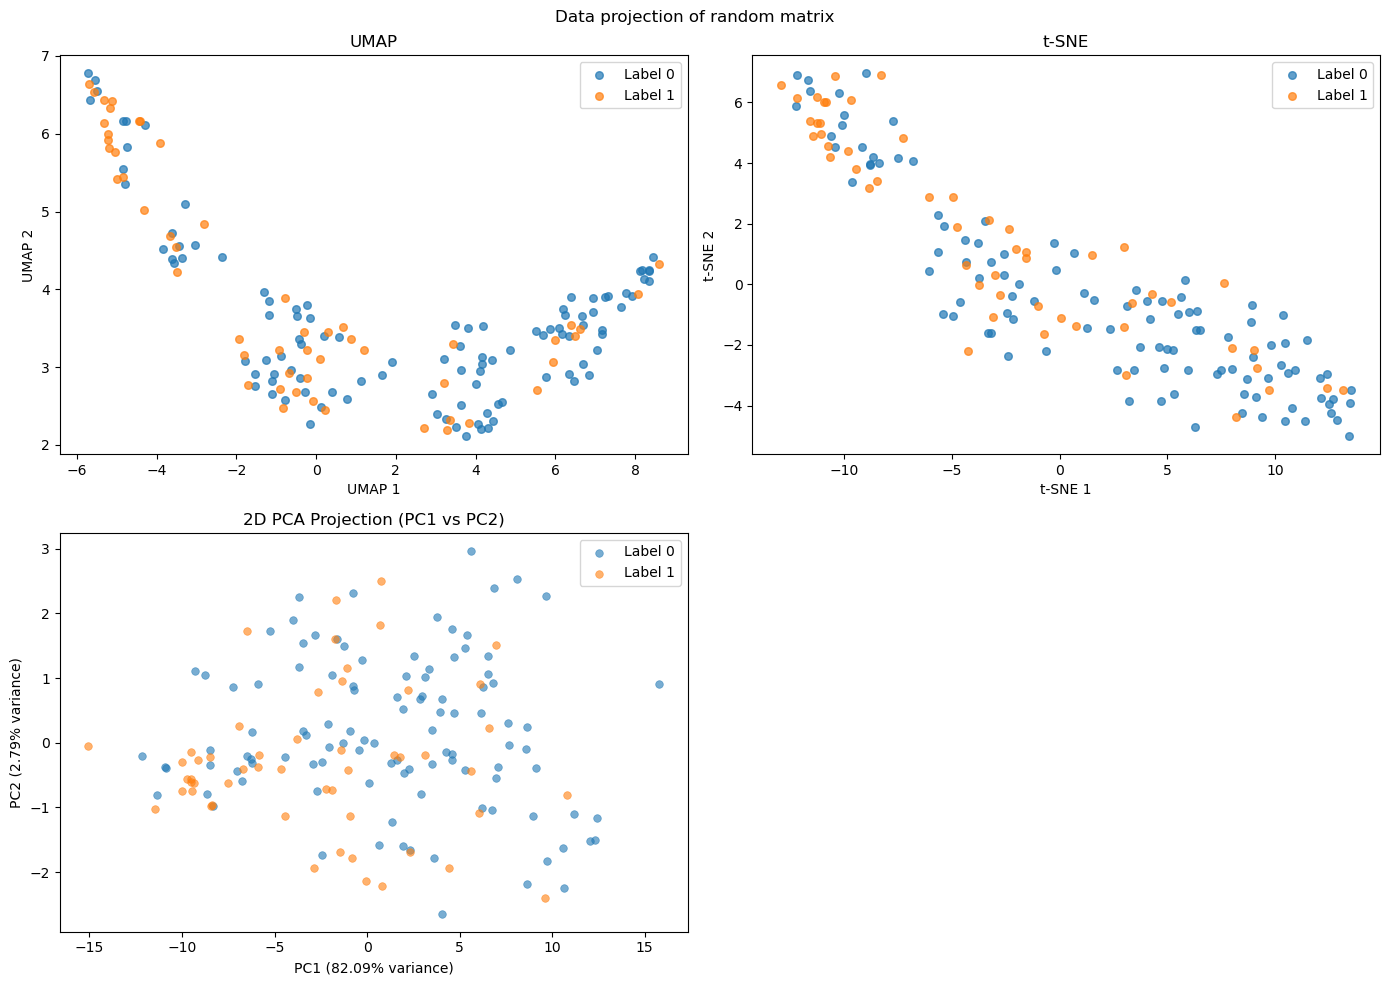

In [35]:
labels = ['cancer_label', "survival_label"]
meta_cols = ['years_to_death', 'days_to_death', 'sample_type', 'patient', 'age_at_index', 'vital_status', 'sex', 'stage', 'grade']
label_cols = meta_cols + labels        
pathw_cols = [col for col in matrix.columns if col not in label_cols]

# ===== Projection after metadata inclusion as features ===== 

matrix_list = (
    meta_pathways_dt["whole"]["full"],
    meta_pathways_dt["whole"]["selected"],
    meta_pathways_dt["whole"]["random"]
)
matrix_names_list = ["full library", "selected", "random"]

for matrix, name in zip(matrix_list, matrix_names_list) :

    feature_cols = [col for col in matrix.columns if col not in label_cols]
    X_kbest = matrix[feature_cols]
    y_kbest = matrix['survival_label'].values

    # Final feature selection k choice
    selector = SelectKBest(f_classif, k=50)    
    selector.fit(X_kbest, y_kbest)
    selected_pathways_kbest = X_kbest.columns[selector.get_support()].tolist()
    pathways_matrix_selected = X_kbest[selected_pathways_kbest].copy()

    # Prepare data for dimensionality reduction
    X = pathways_matrix_selected.values
    labels = matrix['survival_label'].values

    # UMAP
    umap = UMAP(n_components=2, random_state=42)
    umap_embedding = umap.fit_transform(X)

    # t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_embedding = tsne.fit_transform(X)

    # PCA 
    pca = PCA()
    X_train_pca = pca.fit_transform(X)

    # ----- Plot -----
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # UMAP plot
    for label_val in [0, 1]:
        mask = labels == label_val
        axes[0,0].scatter(umap_embedding[mask, 0], umap_embedding[mask, 1], 
                        label=f'Label {label_val}', s=30, alpha=0.7)
    axes[0,0].set_title('UMAP')
    axes[0,0].set_xlabel('UMAP 1')
    axes[0,0].set_ylabel('UMAP 2')
    axes[0,0].legend()

    # t-SNE plot
    for label_val in [0, 1]:
        mask = labels == label_val
        axes[0,1].scatter(tsne_embedding[mask, 0], tsne_embedding[mask, 1], 
                        label=f'Label {label_val}', s=30, alpha=0.7)
    axes[0,1].set_title('t-SNE')
    axes[0,1].set_xlabel('t-SNE 1')
    axes[0,1].set_ylabel('t-SNE 2')
    axes[0,1].legend()

    # PCA plot
    for label_val in [0, 1]:
        mask = labels == label_val
        axes[1,0].scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], 
                        label=f'Label {label_val}', s=30, alpha=0.6, 
                        linewidth=0.5)
    axes[1,0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)')
    axes[1,0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)')
    axes[1,0].set_title('2D PCA Projection (PC1 vs PC2)')
    axes[1,0].legend()

    # Hide the empty subplot
    axes[1,1].axis('off')

    plt.suptitle(f"Data projection of {name} matrix")
    plt.tight_layout()
    plt.show()

# Save

In [36]:
# meta_pathways_dt contains matrices after SelectKBest k=50 
# meta_pathways_dt[dataset_name] keys : whole, training, testing
# meta_pathways_dt[dataset_name][type_name] keys : full, selected, random

print("Saving : ")
for dataset_name in meta_pathways_dt.keys() :
    print(f"\n")
    for type_name, pathways_matrix in meta_pathways_dt[dataset_name].items() :
        file_name = f"{dataset_name}data_{type_name}pathways_matrix_surv.csv"
        pathways_matrix.to_csv(final_folder / file_name)
        print(file_name, pathways_matrix.shape)
        

Saving : 


wholedata_fullpathways_matrix_surv.csv (160, 3660)
wholedata_selectedpathways_matrix_surv.csv (160, 374)
wholedata_randompathways_matrix_surv.csv (160, 374)


trainingdata_fullpathways_matrix_surv.csv (112, 3659)
trainingdata_selectedpathways_matrix_surv.csv (112, 373)
trainingdata_randompathways_matrix_surv.csv (112, 373)


testingdata_fullpathways_matrix_surv.csv (48, 3657)
testingdata_selectedpathways_matrix_surv.csv (48, 371)
testingdata_randompathways_matrix_surv.csv (48, 371)


In [37]:
run_end = time.time()
print(f"This script takes {(run_end-run_start)/60} min to run.")


This script takes 14.973739731311799 min to run.


TO DO maybe :
- Fanny wants to test the scarcity, and use GO instead of MSIgDB for pathways mapping